# Notebook : 02_model_training_unet.ipynb
- Objectif : entraîner un premier modèle U-Net sur Cityscapes (8 classes) avec pipeline MLOps
# 1 - Imports & préparation

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import mlflow
mlflow.set_tracking_uri("file:./mlruns")

from dotenv import load_dotenv
load_dotenv()

False

In [2]:
# Remonter à la racine du projet
project_root = Path("..").resolve()

# Ajouter src/ au PYTHONPATH
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [3]:
from utils.utils import plot_history

# 2 - Unet
## 2.1 - Chargement des fonctions d'entraînement

In [4]:
from model_training.train_unet import train_unet_model_from_npz
from utils.utils import plot_history

## 2.2 - Chargement des données .npz

In [5]:
print("[INFO] Chargement des fichiers .npz...")
data_dir = project_root / "data" / "processed" / "augmented"
train = np.load(data_dir / "train.npz")
val   = np.load(data_dir / "val.npz")

X_train, Y_train = train["X"], train["Y"]
X_val, Y_val     = val["X"], val["Y"]

print(f"✅ Train shape : {X_train.shape} / {Y_train.shape}")
print(f"✅ Val shape   : {X_val.shape} / {Y_val.shape}")

[INFO] Chargement des fichiers .npz...
✅ Train shape : (2380, 256, 256, 3) / (2380, 256, 256)
✅ Val shape   : (297, 256, 256, 3) / (297, 256, 256)


## 2.2 - Paramètres

In [6]:
params_test = {
    'img_size': (256, 256),
    'epochs': 1,
    'batch_size': 4,
    'use_early_stopping': True,
    'force_retrain': False
}

params_prod = {
    'img_size': (256, 256),
    'epochs': 40,
    'batch_size': 8,
    'use_early_stopping': True,
    'force_retrain': False
}

# 3 - Entraînements
## 3.1 - Test rapide

In [7]:
print("\n🔁 Entraînement rapide (TEST)...")
model_test, history_test = train_unet_model_from_npz(
    X_train, Y_train, X_val, Y_val,
    **params_test
)


🔁 Entraînement rapide (TEST)...
🔄 Lancement du serveur MLflow local...
✅ Serveur MLflow démarré sur http://127.0.0.1:5000
[LOG] ➤ train_unet_model_from_npz appelé
[INFO] Modèle existant détecté : models\unet_mini_npz_256x256_bs4_ep1.h5


### 3.1.1 - Résumé du modèle et courbe d'apprentissage

In [8]:
print("\n🧠 Résumé du modèle UNet Mini (TEST) :")
model_test.summary()
from pathlib import Path
output_dir = project_root / "outputs" / "figures"
output_dir.mkdir(parents=True, exist_ok = True)

plot_history(history_test, output_dir / "history_test.png")


🧠 Résumé du modèle UNet Mini (TEST) :
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                      

### 3.1.2 - courbes IoU et Dice

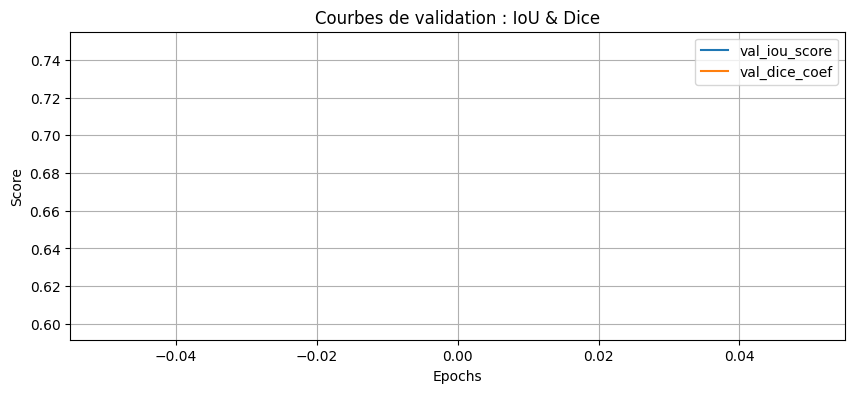

In [9]:
plt.figure(figsize=(10,4))
plt.plot(history_test['val_iou_score'], label='val_iou_score')
plt.plot(history_test['val_dice_coef'], label='val_dice_coef')
plt.title('Courbes de validation : IoU & Dice')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

## 3.2 - Entraînement PROD complet

In [10]:
print("\n🚀 Entraînement complet (PROD)...")
model_prod, history_prod = train_unet_model_from_npz(
    X_train, Y_train, X_val, Y_val,
    **params_prod
)


🚀 Entraînement complet (PROD)...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_model_from_npz appelé
[INFO] Modèle existant détecté : models\unet_mini_npz_256x256_bs8_ep40.h5


### 3.2.1 - Résumé final du modèle + graphe

In [11]:
print("\n🧠 Résumé du modèle UNet Mini (PROD) :")
model_prod.summary()
plot_history(history_prod, output_dir / "history_prod.png")


🧠 Résumé du modèle UNet Mini (PROD) :
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d_8[0][0]']               
                                )                    

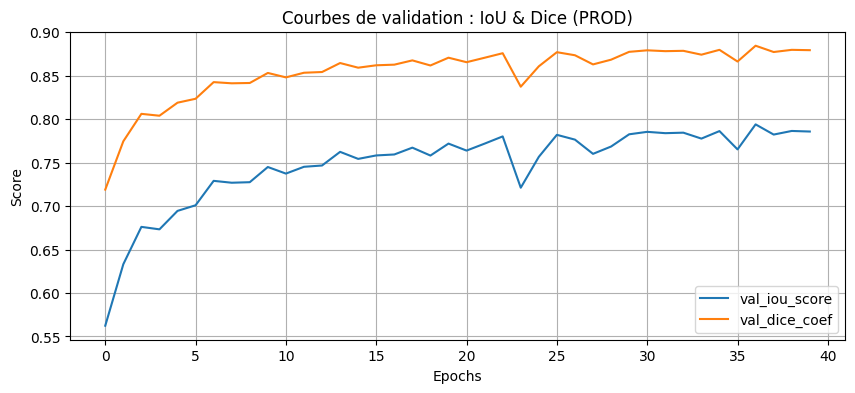

In [12]:
plt.figure(figsize=(10,4))
plt.plot(history_prod['val_iou_score'], label='val_iou_score')
plt.plot(history_prod['val_dice_coef'], label='val_dice_coef')
plt.title('Courbes de validation : IoU & Dice (PROD)')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()